# Redes de Convolução Dilatadas

Nesta aula, vamos ver como usar redes de convolução para prever o tempo. Para isso, vamos usar um tipo de CNN que suporta uma operação diferente de convolução, a _convolução dilatada causal_.

In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Introdução

CNNs foram projetadas principalmente para processamento espacial. Elas, contudo, são usadas também como sucesso para entradas de natureza sequencial, como frases, áudio etc. Nestes casos, elas tiram proveito do contexto observado na sequência, sem lidar realmente com o seu encadeamento sequêncial. Contudo, mais recentemente, arquiteturas têm sido propostas que são capazes de lidar mesmo com a natureza sequencial da informação. Um exemplo são as CNNs dilatadas (DC-CNNs), ou seja, CNNs com operações de convolução causais dilatadas.

A ideia geral das DC-CNNs é explorar o contexto da informação considerando sua direção causal. Em termos práticos, operações de convolução nestas CNNs são restritas a apenas uma direção. É mais fácil entender isso com um exemplo. Abaixo, temos o esquema de uma convolução causal 1-D de largura 2. Ou seja, cada neurônio observa duas entradas. Como a convolução é causal, note que o $t$-ésimo neurônio só pode observar entradas $t$ e $t-1$.

<img src="images/WaveNet_causalconv.png" alt="Convolução causal" style="width: 600px;"/>

Este tipo de operação permite a previsão de uma saída, pela observação de entradas anteriores a ela. Contudo, note no exemplo, que para observar 5 entradas, a rede precisa de 3 camadas ocultas. Para observar uma série com 16 entradas, seriam necessárias 14 camadas, tornando a rede rapidamente  inviável para sequencias maiores.

Uma forma de resolver este problema é atraves de _convoluções dilatadas_, ou seja convoluções aplicadas à entrada com intervalos de tamanhos pré-definidos. Por exemplo, com apenas 3 camadas é possível observar 16 entradas se cada camada possuir o dobro de intervalos da camada anterior, como visto abaixo:

<img src="images/WaveNet_dilatedconv.png" alt="Convolução causal" style="width: 600px;"/>

A quantidade de intervalos entre duas observações é chamada _fator de dilatação_. Uma convolução normal pode ser vista como uma convolução em que o fator de dilatação $k = 1$. Com $k=2$, a convolução saltaria uma a cada duas entradas. Com $k=4$, seriam saltadas 3 entradas. 

Estas operações de convolução possibilitam que se aumente o "campo receptivo" de um neurônio exponencialmente com um aumento apenas linear do número de parâmetros. Assim, é possível se explorar a sequência de elementos tanto de forma detalhada quanto geral, sem grande custo processamento.

Assim, usando convoluções causais dilatadas, é possível usar CNNs para preverem o próximo elemento de uma sequência, tornando possível o seu uso como previsores temporais, como ilustrado abaixo:

<img src="images/dilation_animation.gif" alt="Animação de dilations" style="width: 500px;"/>

Neste notebook, vamos implementar esta estratégia de previsão.

### Uma arquitetura CNN dilatada

Em paricular, vamos implementar a rede _seriesnet_, uma DN-CNN com a arquitetura ilustrada a seguir:

<img src="images/dilatedCNN.png" alt="CNN dilatada" style="width: 500px;"/>

Nesta arquitetura, em particular, 7 camadas são empilhadas. Cada camada corresponde a um bloco com diferente fator de dilatação (bloco DC-CNN). A saída de todos os blocos é somada e transformada por uma operação _relu_. O resultado é então combinado em uma convolução de largura 1 que gera a previsão $\hat{y}$. 

Cada bloco DC-CNN corresponde a um conjunto de filtros de convolução causal dilatada, com saída tanto para o próximo bloco quanto para o somador final. Ambas as saídas ainda são transformadas por uma operação relu e combinadas via camadas de convolução 1x1. A saída para o próximo bloco é residual. A seguir, temos a implementação desta arquitetura em Keras.

In [3]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def block(block_input):        
        residual =    block_input
        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='causal', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(block_input)                    
        selu_out =    Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
        
        c1x1_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
                      
        block_out =   Add()([residual, c1x1_out])
        
        return block_out, skip_out
    return block

In [5]:
def DC_CNN_Model(length):
    visible = Input(shape=(length, 1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(visible)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])  
    
    l9 =   Activation('relu')(l8)
           
    yhat =  Conv1D(1,1, activation='linear', use_bias=False, 
            kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
            kernel_regularizer=l2(0.001))(l9)

    model = Model(inputs=visible, outputs=yhat)
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    return model

### Usando CNNs dilatadas para previsão de séries de tempo

Para testar nosso modelo, vamos usar uma série com informaçoes sobre o número de passageiros em vôos nos EUA entre 1949 e 1961.

In [6]:
import pandas as pd

In [7]:
airline = pd.read_csv('data/airline.csv')

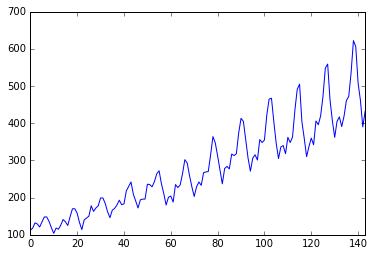

In [8]:
airline['passengers'].plot()

Esta série apresenta clara sazonalidade e uma tendência de crescimento. A seguir, Vamos agora fazer uma previsão para um horizonte de 40 dias:

In [9]:
forecast_horizon = 40

In [10]:
Xpast = airline['passengers'].iloc[:-forecast_horizon]
Xreal = airline['passengers'].iloc[-forecast_horizon:] 

In [11]:
Xpast = np.atleast_2d(np.asarray(Xpast)).T

In [12]:
length = len(Xpast)-1

In [13]:
model = DC_CNN_Model(length)

In [14]:
X = Xpast[:-1].reshape(1,length,1)
y = Xpast[1:].reshape(1,length,1)    

In [15]:
print(X[0,:5,:].T)
print(y[0,:5,:].T)

[[112 118 132 129 121]]
[[118 132 129 121 135]]


In [16]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 1s - loss: 228.4865 - mean_squared_error: 59145.7812
Epoch 2/500
1/1 [==============================] - 0s - loss: 228.3526 - mean_squared_error: 59076.1562
Epoch 3/500
1/1 [==============================] - 0s - loss: 228.2297 - mean_squared_error: 59012.2422
Epoch 4/500
1/1 [==============================] - 0s - loss: 228.1179 - mean_squared_error: 58954.1445
Epoch 5/500
1/1 [==============================] - 0s - loss: 228.0168 - mean_squared_error: 58901.5078
Epoch 6/500
1/1 [==============================] - 0s - loss: 227.9260 - mean_squared_error: 58854.2539
Epoch 7/500
1/1 [==============================] - 0s - loss: 227.8477 - mean_squared_error: 58813.4648
Epoch 8/500
1/1 [==============================] - 0s - loss: 227.7767 - mean_squared_error: 58776.5195
Epoch 9/500
1/1 [==============================] - 0s - loss: 227.7154 - mean_squared_error: 58744.5078
Epoch 10/500
1/1 [==============================] - 0s - loss: 2

1/1 [==============================] - 0s - loss: 211.9634 - mean_squared_error: 50836.3125
Epoch 80/500
1/1 [==============================] - 0s - loss: 210.0585 - mean_squared_error: 49918.2617
Epoch 81/500
1/1 [==============================] - 0s - loss: 207.9449 - mean_squared_error: 48909.3164
Epoch 82/500
1/1 [==============================] - 0s - loss: 205.6006 - mean_squared_error: 47802.1016
Epoch 83/500
1/1 [==============================] - 0s - loss: 203.0004 - mean_squared_error: 46588.7070
Epoch 84/500
1/1 [==============================] - 0s - loss: 200.1167 - mean_squared_error: 45261.1875
Epoch 85/500
1/1 [==============================] - 0s - loss: 196.9191 - mean_squared_error: 43811.5273
Epoch 86/500
1/1 [==============================] - 0s - loss: 193.3731 - mean_squared_error: 42231.6406
Epoch 87/500
1/1 [==============================] - 0s - loss: 189.4410 - mean_squared_error: 40513.8164
Epoch 88/500
1/1 [==============================] - 0s - loss: 185.0

1/1 [==============================] - 0s - loss: 28.7869 - mean_squared_error: 1220.9252
Epoch 158/500
1/1 [==============================] - 0s - loss: 28.6519 - mean_squared_error: 1212.8239
Epoch 159/500
1/1 [==============================] - 0s - loss: 28.5056 - mean_squared_error: 1206.4045
Epoch 160/500
1/1 [==============================] - 0s - loss: 28.3546 - mean_squared_error: 1202.8127
Epoch 161/500
1/1 [==============================] - 0s - loss: 28.2188 - mean_squared_error: 1202.7549
Epoch 162/500
1/1 [==============================] - 0s - loss: 28.1328 - mean_squared_error: 1206.1807
Epoch 163/500
1/1 [==============================] - 0s - loss: 28.0585 - mean_squared_error: 1210.5555
Epoch 164/500
1/1 [==============================] - 0s - loss: 27.9984 - mean_squared_error: 1214.6992
Epoch 165/500
1/1 [==============================] - 0s - loss: 27.9322 - mean_squared_error: 1215.5271
Epoch 166/500
1/1 [==============================] - 0s - loss: 27.8356 - mean

1/1 [==============================] - 0s - loss: 22.5306 - mean_squared_error: 904.1255
Epoch 237/500
1/1 [==============================] - 0s - loss: 22.4983 - mean_squared_error: 905.0781
Epoch 238/500
1/1 [==============================] - 0s - loss: 22.4667 - mean_squared_error: 904.4219
Epoch 239/500
1/1 [==============================] - 0s - loss: 22.4313 - mean_squared_error: 902.2073
Epoch 240/500
1/1 [==============================] - 0s - loss: 22.3931 - mean_squared_error: 898.5938
Epoch 241/500
1/1 [==============================] - 0s - loss: 22.3579 - mean_squared_error: 894.9495
Epoch 242/500
1/1 [==============================] - 0s - loss: 22.3274 - mean_squared_error: 892.7311
Epoch 243/500
1/1 [==============================] - 0s - loss: 22.2944 - mean_squared_error: 892.3597
Epoch 244/500
1/1 [==============================] - 0s - loss: 22.2632 - mean_squared_error: 892.3047
Epoch 245/500
1/1 [==============================] - 0s - loss: 22.2340 - mean_squared_

1/1 [==============================] - 0s - loss: 20.2907 - mean_squared_error: 714.8247
Epoch 316/500
1/1 [==============================] - 0s - loss: 20.2686 - mean_squared_error: 712.6674
Epoch 317/500
1/1 [==============================] - 0s - loss: 20.2503 - mean_squared_error: 713.9510
Epoch 318/500
1/1 [==============================] - 0s - loss: 20.2292 - mean_squared_error: 711.4210
Epoch 319/500
1/1 [==============================] - 0s - loss: 20.2139 - mean_squared_error: 704.3215
Epoch 320/500
1/1 [==============================] - 0s - loss: 20.1853 - mean_squared_error: 703.4027
Epoch 321/500
1/1 [==============================] - 0s - loss: 20.1904 - mean_squared_error: 706.7775
Epoch 322/500
1/1 [==============================] - 0s - loss: 20.1500 - mean_squared_error: 701.3231
Epoch 323/500
1/1 [==============================] - 0s - loss: 20.1575 - mean_squared_error: 693.6491
Epoch 324/500
1/1 [==============================] - 0s - loss: 20.1235 - mean_squared_

1/1 [==============================] - 0s - loss: 18.6423 - mean_squared_error: 585.9592
Epoch 395/500
1/1 [==============================] - 0s - loss: 18.6146 - mean_squared_error: 585.6405
Epoch 396/500
1/1 [==============================] - 0s - loss: 18.6015 - mean_squared_error: 585.0466
Epoch 397/500
1/1 [==============================] - 0s - loss: 18.6401 - mean_squared_error: 580.7820
Epoch 398/500
1/1 [==============================] - 0s - loss: 18.6386 - mean_squared_error: 579.5269
Epoch 399/500
1/1 [==============================] - 0s - loss: 18.5562 - mean_squared_error: 580.3408
Epoch 400/500
1/1 [==============================] - 0s - loss: 18.6780 - mean_squared_error: 586.9567
Epoch 401/500
1/1 [==============================] - 0s - loss: 18.5545 - mean_squared_error: 580.6774
Epoch 402/500
1/1 [==============================] - 0s - loss: 18.5907 - mean_squared_error: 575.1199
Epoch 403/500
1/1 [==============================] - 0s - loss: 18.6021 - mean_squared_

1/1 [==============================] - 0s - loss: 17.8634 - mean_squared_error: 525.9350
Epoch 474/500
1/1 [==============================] - 0s - loss: 17.8443 - mean_squared_error: 527.9446
Epoch 475/500
1/1 [==============================] - 0s - loss: 17.8471 - mean_squared_error: 530.3043
Epoch 476/500
1/1 [==============================] - 0s - loss: 17.8304 - mean_squared_error: 527.2864
Epoch 477/500
1/1 [==============================] - 0s - loss: 17.8251 - mean_squared_error: 526.3867
Epoch 478/500
1/1 [==============================] - 0s - loss: 17.8150 - mean_squared_error: 527.2982
Epoch 479/500
1/1 [==============================] - 0s - loss: 17.8118 - mean_squared_error: 528.4181
Epoch 480/500
1/1 [==============================] - 0s - loss: 17.8065 - mean_squared_error: 524.2196
Epoch 481/500
1/1 [==============================] - 0s - loss: 17.8086 - mean_squared_error: 522.3806
Epoch 482/500
1/1 [==============================] - 0s - loss: 17.7851 - mean_squared_

In [17]:
X_test_initial = Xpast[1:].reshape(1,length,1)
X_trfit = model.predict(X_test_initial)

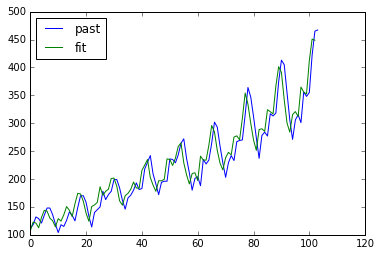

In [18]:
plt.plot(Xpast, label = 'past')
plt.plot(X_trfit.flatten(), label = 'fit')
plt.legend(loc = 'upper left')

In [19]:
preds = np.zeros(forecast_horizon)
preds[0] = model.predict(X_test_initial)[0,-1,0]

for i in range(1, forecast_horizon):
    X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
    preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]

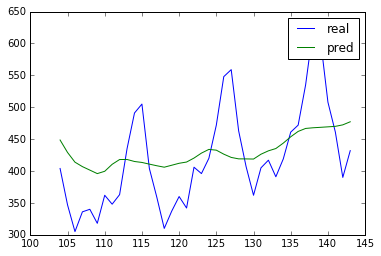

In [20]:
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(preds, index=Xreal.index), label = 'pred')
plt.legend()

Juntando tudo:

In [21]:
def evaluate_timeseries(timeseries, predict_size, n_epochs = 3000):
    # timeseries input is 1-D numpy array
    # forecast_size is the forecast horizon
    
    # remove missing data
    timeseries = timeseries[~pd.isnull(timeseries)]

    length = len(timeseries)-1

    timeseries = np.atleast_2d(np.asarray(timeseries))
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T 

    model = DC_CNN_Model(length)
    #print('\n\nModel input size %d, output size %s' % (model.input_shape, model.output_shape))
    
    model.summary()

    # prime model
    X = timeseries[:-1].reshape(1,length,1)
    y = timeseries[1:].reshape(1,length,1)    
    model.fit(X, y, epochs=n_epochs)
    
    # get fit for training data
    X_test_initial = timeseries[1:].reshape(1,length,1)
    X_trfit = model.predict(X_test_initial) 
        
    # forecast is created by predicting next future 
    # value based on previous predictions
    preds = np.zeros(forecast_horizon)
    preds[0] = model.predict(X_test_initial)[0,-1,0]
    for i in range(1, forecast_horizon):
        X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
        preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]
        
    return preds, X_trfit.flatten()

In [22]:
Xpred, Xfit = evaluate_timeseries(Xpast, forecast_horizon, n_epochs = 4000)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 103, 1)        0                                            
____________________________________________________________________________________________________
conv1d_23 (Conv1D)               (None, 103, 32)       64          input_2[0][0]                    
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 103, 32)       0           conv1d_23[0][0]                  
____________________________________________________________________________________________________
conv1d_25 (Conv1D)               (None, 103, 1)        32          activation_9[0][0]               
___________________________________________________________________________________________

Epoch 1/4000
1/1 [==============================] - 1s - loss: 228.4865 - mean_squared_error: 59145.7812
Epoch 2/4000
1/1 [==============================] - 0s - loss: 228.3526 - mean_squared_error: 59076.1562
Epoch 3/4000
1/1 [==============================] - 0s - loss: 228.2297 - mean_squared_error: 59012.2422
Epoch 4/4000
1/1 [==============================] - 0s - loss: 228.1176 - mean_squared_error: 58953.9961
Epoch 5/4000
1/1 [==============================] - 0s - loss: 228.0164 - mean_squared_error: 58901.3008
Epoch 6/4000
1/1 [==============================] - 0s - loss: 227.9256 - mean_squared_error: 58854.0469
Epoch 7/4000
1/1 [==============================] - 0s - loss: 227.8450 - mean_squared_error: 58812.1172
Epoch 8/4000
1/1 [==============================] - 0s - loss: 227.7745 - mean_squared_error: 58775.3477
Epoch 9/4000
1/1 [==============================] - 0s - loss: 227.7135 - mean_squared_error: 58743.5234
Epoch 10/4000
1/1 [==============================] - 0s

1/1 [==============================] - 0s - loss: 217.8833 - mean_squared_error: 53739.5742
Epoch 79/4000
1/1 [==============================] - 0s - loss: 216.5997 - mean_squared_error: 53102.8398
Epoch 80/4000
1/1 [==============================] - 0s - loss: 215.1718 - mean_squared_error: 52398.9023
Epoch 81/4000
1/1 [==============================] - 0s - loss: 213.5840 - mean_squared_error: 51621.5469
Epoch 82/4000
1/1 [==============================] - 0s - loss: 211.8189 - mean_squared_error: 50764.0977
Epoch 83/4000
1/1 [==============================] - 0s - loss: 209.8576 - mean_squared_error: 49819.4453
Epoch 84/4000
1/1 [==============================] - 0s - loss: 207.6784 - mean_squared_error: 48780.1641
Epoch 85/4000
1/1 [==============================] - 0s - loss: 205.2578 - mean_squared_error: 47638.4141
Epoch 86/4000
1/1 [==============================] - 0s - loss: 202.5694 - mean_squared_error: 46386.0781
Epoch 87/4000
1/1 [==============================] - 0s - lo

1/1 [==============================] - 0s - loss: 29.1012 - mean_squared_error: 1244.3563
Epoch 156/4000
1/1 [==============================] - 0s - loss: 29.0403 - mean_squared_error: 1238.9139
Epoch 157/4000
1/1 [==============================] - 0s - loss: 28.9430 - mean_squared_error: 1231.6162
Epoch 158/4000
1/1 [==============================] - 0s - loss: 28.8217 - mean_squared_error: 1222.9337
Epoch 159/4000
1/1 [==============================] - 0s - loss: 28.6913 - mean_squared_error: 1214.3124
Epoch 160/4000
1/1 [==============================] - 0s - loss: 28.5490 - mean_squared_error: 1206.8651
Epoch 161/4000
1/1 [==============================] - 0s - loss: 28.3962 - mean_squared_error: 1201.7319
Epoch 162/4000
1/1 [==============================] - 0s - loss: 28.2505 - mean_squared_error: 1200.1074
Epoch 163/4000
1/1 [==============================] - 0s - loss: 28.1417 - mean_squared_error: 1201.9971
Epoch 164/4000
1/1 [==============================] - 0s - loss: 28.06

1/1 [==============================] - 0s - loss: 22.6164 - mean_squared_error: 905.8269
Epoch 234/4000
1/1 [==============================] - 0s - loss: 22.5765 - mean_squared_error: 904.1656
Epoch 235/4000
1/1 [==============================] - 0s - loss: 22.5371 - mean_squared_error: 903.1066
Epoch 236/4000
1/1 [==============================] - 0s - loss: 22.4979 - mean_squared_error: 903.1801
Epoch 237/4000
1/1 [==============================] - 0s - loss: 22.4631 - mean_squared_error: 902.9088
Epoch 238/4000
1/1 [==============================] - 0s - loss: 22.4291 - mean_squared_error: 902.2472
Epoch 239/4000
1/1 [==============================] - 0s - loss: 22.3929 - mean_squared_error: 899.9555
Epoch 240/4000
1/1 [==============================] - 0s - loss: 22.3573 - mean_squared_error: 897.4321
Epoch 241/4000
1/1 [==============================] - 0s - loss: 22.3218 - mean_squared_error: 894.7159
Epoch 242/4000
1/1 [==============================] - 0s - loss: 22.2884 - mean

1/1 [==============================] - 0s - loss: 20.3416 - mean_squared_error: 726.6546
Epoch 312/4000
1/1 [==============================] - 0s - loss: 20.3260 - mean_squared_error: 724.7024
Epoch 313/4000
1/1 [==============================] - 0s - loss: 20.3342 - mean_squared_error: 715.2087
Epoch 314/4000
1/1 [==============================] - 0s - loss: 20.3075 - mean_squared_error: 713.6056
Epoch 315/4000
1/1 [==============================] - 0s - loss: 20.2860 - mean_squared_error: 719.0203
Epoch 316/4000
1/1 [==============================] - 0s - loss: 20.2663 - mean_squared_error: 716.6080
Epoch 317/4000
1/1 [==============================] - 0s - loss: 20.2507 - mean_squared_error: 707.5359
Epoch 318/4000
1/1 [==============================] - 0s - loss: 20.2426 - mean_squared_error: 704.3934
Epoch 319/4000
1/1 [==============================] - 0s - loss: 20.2030 - mean_squared_error: 705.6750
Epoch 320/4000
1/1 [==============================] - 0s - loss: 20.1893 - mean

1/1 [==============================] - 0s - loss: 18.8027 - mean_squared_error: 600.7546
Epoch 390/4000
1/1 [==============================] - 0s - loss: 18.7301 - mean_squared_error: 596.2521
Epoch 391/4000
1/1 [==============================] - 0s - loss: 18.7282 - mean_squared_error: 594.0585
Epoch 392/4000
1/1 [==============================] - 0s - loss: 18.6839 - mean_squared_error: 594.4409
Epoch 393/4000
1/1 [==============================] - 0s - loss: 18.6682 - mean_squared_error: 593.5266
Epoch 394/4000
1/1 [==============================] - 0s - loss: 18.6782 - mean_squared_error: 590.2148
Epoch 395/4000
1/1 [==============================] - 0s - loss: 18.6434 - mean_squared_error: 589.4801
Epoch 396/4000
1/1 [==============================] - 0s - loss: 18.6478 - mean_squared_error: 591.6255
Epoch 397/4000
1/1 [==============================] - 0s - loss: 18.5958 - mean_squared_error: 588.3863
Epoch 398/4000
1/1 [==============================] - 0s - loss: 18.6622 - mean

1/1 [==============================] - 0s - loss: 17.9310 - mean_squared_error: 533.1254
Epoch 468/4000
1/1 [==============================] - 0s - loss: 17.9153 - mean_squared_error: 529.4984
Epoch 469/4000
1/1 [==============================] - 0s - loss: 17.9059 - mean_squared_error: 528.2318
Epoch 470/4000
1/1 [==============================] - 0s - loss: 17.8910 - mean_squared_error: 528.9949
Epoch 471/4000
1/1 [==============================] - 0s - loss: 17.8813 - mean_squared_error: 528.5535
Epoch 472/4000
1/1 [==============================] - 0s - loss: 17.8736 - mean_squared_error: 525.3975
Epoch 473/4000
1/1 [==============================] - 0s - loss: 17.8628 - mean_squared_error: 524.4800
Epoch 474/4000
1/1 [==============================] - 0s - loss: 17.8486 - mean_squared_error: 525.5661
Epoch 475/4000
1/1 [==============================] - 0s - loss: 17.8455 - mean_squared_error: 527.1406
Epoch 476/4000
1/1 [==============================] - 0s - loss: 17.8302 - mean

1/1 [==============================] - 0s - loss: 17.2276 - mean_squared_error: 508.1709
Epoch 546/4000
1/1 [==============================] - 0s - loss: 17.2183 - mean_squared_error: 507.6196
Epoch 547/4000
1/1 [==============================] - 0s - loss: 17.2127 - mean_squared_error: 502.8863
Epoch 548/4000
1/1 [==============================] - 0s - loss: 17.1982 - mean_squared_error: 505.1650
Epoch 549/4000
1/1 [==============================] - 0s - loss: 17.1951 - mean_squared_error: 508.6004
Epoch 550/4000
1/1 [==============================] - 0s - loss: 17.1838 - mean_squared_error: 507.2093
Epoch 551/4000
1/1 [==============================] - 0s - loss: 17.1814 - mean_squared_error: 501.7071
Epoch 552/4000
1/1 [==============================] - 0s - loss: 17.1668 - mean_squared_error: 503.3589
Epoch 553/4000
1/1 [==============================] - 0s - loss: 17.1721 - mean_squared_error: 512.1524
Epoch 554/4000
1/1 [==============================] - 0s - loss: 17.1626 - mean

1/1 [==============================] - 0s - loss: 16.8660 - mean_squared_error: 523.5098
Epoch 624/4000
1/1 [==============================] - 0s - loss: 16.8744 - mean_squared_error: 516.7931
Epoch 625/4000
1/1 [==============================] - 0s - loss: 16.8642 - mean_squared_error: 527.6985
Epoch 626/4000
1/1 [==============================] - 0s - loss: 16.8811 - mean_squared_error: 535.8875
Epoch 627/4000
1/1 [==============================] - 0s - loss: 16.8592 - mean_squared_error: 526.6271
Epoch 628/4000
1/1 [==============================] - 0s - loss: 16.8718 - mean_squared_error: 516.6409
Epoch 629/4000
1/1 [==============================] - 0s - loss: 16.8530 - mean_squared_error: 523.6779
Epoch 630/4000
1/1 [==============================] - 0s - loss: 16.8532 - mean_squared_error: 527.9434
Epoch 631/4000
1/1 [==============================] - 0s - loss: 16.8516 - mean_squared_error: 529.3513
Epoch 632/4000
1/1 [==============================] - 0s - loss: 16.8484 - mean

1/1 [==============================] - 0s - loss: 16.7504 - mean_squared_error: 522.1328
Epoch 702/4000
1/1 [==============================] - 0s - loss: 16.7316 - mean_squared_error: 525.8509
Epoch 703/4000
1/1 [==============================] - 0s - loss: 16.6904 - mean_squared_error: 548.5560
Epoch 704/4000
1/1 [==============================] - 0s - loss: 16.7797 - mean_squared_error: 568.9440
Epoch 705/4000
1/1 [==============================] - 0s - loss: 16.6891 - mean_squared_error: 535.7601
Epoch 706/4000
1/1 [==============================] - 0s - loss: 16.7536 - mean_squared_error: 517.8535
Epoch 707/4000
1/1 [==============================] - 0s - loss: 16.7483 - mean_squared_error: 518.7113
Epoch 708/4000
1/1 [==============================] - 0s - loss: 16.6814 - mean_squared_error: 536.7158
Epoch 709/4000
1/1 [==============================] - 0s - loss: 16.7020 - mean_squared_error: 557.6705
Epoch 710/4000
1/1 [==============================] - 0s - loss: 16.6773 - mean

1/1 [==============================] - 0s - loss: 17.0175 - mean_squared_error: 614.4900
Epoch 780/4000
1/1 [==============================] - 0s - loss: 16.8706 - mean_squared_error: 598.9901
Epoch 781/4000
1/1 [==============================] - 0s - loss: 16.6007 - mean_squared_error: 522.2065
Epoch 782/4000
1/1 [==============================] - 0s - loss: 16.8986 - mean_squared_error: 490.7538
Epoch 783/4000
1/1 [==============================] - 0s - loss: 16.8854 - mean_squared_error: 491.4140
Epoch 784/4000
1/1 [==============================] - 0s - loss: 16.6015 - mean_squared_error: 521.0294
Epoch 785/4000
1/1 [==============================] - 0s - loss: 16.6947 - mean_squared_error: 580.0425
Epoch 786/4000
1/1 [==============================] - 0s - loss: 16.7246 - mean_squared_error: 583.4858
Epoch 787/4000
1/1 [==============================] - 0s - loss: 16.5700 - mean_squared_error: 527.6476
Epoch 788/4000
1/1 [==============================] - 0s - loss: 16.6932 - mean

1/1 [==============================] - 0s - loss: 16.7410 - mean_squared_error: 591.5635
Epoch 858/4000
1/1 [==============================] - 0s - loss: 16.5481 - mean_squared_error: 571.1528
Epoch 859/4000
1/1 [==============================] - 0s - loss: 16.4857 - mean_squared_error: 512.1663
Epoch 860/4000
1/1 [==============================] - 0s - loss: 16.7798 - mean_squared_error: 487.3597
Epoch 861/4000
1/1 [==============================] - 0s - loss: 16.7323 - mean_squared_error: 489.7008
Epoch 862/4000
1/1 [==============================] - 0s - loss: 16.4494 - mean_squared_error: 520.1497
Epoch 863/4000
1/1 [==============================] - 0s - loss: 16.5964 - mean_squared_error: 576.6095
Epoch 864/4000
1/1 [==============================] - 0s - loss: 16.5661 - mean_squared_error: 573.5756
Epoch 865/4000
1/1 [==============================] - 0s - loss: 16.4490 - mean_squared_error: 519.0742
Epoch 866/4000
1/1 [==============================] - 0s - loss: 16.6263 - mean

1/1 [==============================] - 0s - loss: 16.2774 - mean_squared_error: 531.7634
Epoch 936/4000
1/1 [==============================] - 0s - loss: 16.2999 - mean_squared_error: 546.2235
Epoch 937/4000
1/1 [==============================] - 0s - loss: 16.2929 - mean_squared_error: 544.0532
Epoch 938/4000
1/1 [==============================] - 0s - loss: 16.2702 - mean_squared_error: 530.9749
Epoch 939/4000
1/1 [==============================] - 0s - loss: 16.2751 - mean_squared_error: 527.4258
Epoch 940/4000
1/1 [==============================] - 0s - loss: 16.2682 - mean_squared_error: 537.0065
Epoch 941/4000
1/1 [==============================] - 0s - loss: 16.2630 - mean_squared_error: 534.5891
Epoch 942/4000
1/1 [==============================] - 0s - loss: 16.2711 - mean_squared_error: 527.7305
Epoch 943/4000
1/1 [==============================] - 0s - loss: 16.2602 - mean_squared_error: 535.3500
Epoch 944/4000
1/1 [==============================] - 0s - loss: 16.2565 - mean

1/1 [==============================] - 0s - loss: 16.2167 - mean_squared_error: 512.5410
Epoch 1014/4000
1/1 [==============================] - 0s - loss: 16.2966 - mean_squared_error: 500.3350
Epoch 1015/4000
1/1 [==============================] - 0s - loss: 16.1958 - mean_squared_error: 517.0034
Epoch 1016/4000
1/1 [==============================] - 0s - loss: 16.2575 - mean_squared_error: 550.8685
Epoch 1017/4000
1/1 [==============================] - 0s - loss: 16.2239 - mean_squared_error: 544.8086
Epoch 1018/4000
1/1 [==============================] - 0s - loss: 16.1964 - mean_squared_error: 516.1451
Epoch 1019/4000
1/1 [==============================] - 0s - loss: 16.2463 - mean_squared_error: 506.8483
Epoch 1020/4000
1/1 [==============================] - 0s - loss: 16.1886 - mean_squared_error: 517.0973
Epoch 1021/4000
1/1 [==============================] - 0s - loss: 16.2063 - mean_squared_error: 542.6740
Epoch 1022/4000
1/1 [==============================] - 0s - loss: 16.20

1/1 [==============================] - 0s - loss: 16.0759 - mean_squared_error: 518.6292
Epoch 1092/4000
1/1 [==============================] - 0s - loss: 16.1119 - mean_squared_error: 534.9940
Epoch 1093/4000
1/1 [==============================] - 0s - loss: 16.0634 - mean_squared_error: 525.0682
Epoch 1094/4000
1/1 [==============================] - 0s - loss: 16.0840 - mean_squared_error: 514.9822
Epoch 1095/4000
1/1 [==============================] - 0s - loss: 16.0621 - mean_squared_error: 521.3409
Epoch 1096/4000
1/1 [==============================] - 0s - loss: 16.1353 - mean_squared_error: 539.2886
Epoch 1097/4000
1/1 [==============================] - 0s - loss: 16.0848 - mean_squared_error: 529.9207
Epoch 1098/4000
1/1 [==============================] - 0s - loss: 16.1655 - mean_squared_error: 500.5248
Epoch 1099/4000
1/1 [==============================] - 0s - loss: 16.1915 - mean_squared_error: 497.2870
Epoch 1100/4000
1/1 [==============================] - 0s - loss: 16.06

1/1 [==============================] - 0s - loss: 16.0274 - mean_squared_error: 529.3804
Epoch 1170/4000
1/1 [==============================] - 0s - loss: 16.0364 - mean_squared_error: 502.5716
Epoch 1171/4000
1/1 [==============================] - 0s - loss: 16.0388 - mean_squared_error: 501.7555
Epoch 1172/4000
1/1 [==============================] - 0s - loss: 15.9967 - mean_squared_error: 523.5796
Epoch 1173/4000
1/1 [==============================] - 0s - loss: 15.9801 - mean_squared_error: 520.6718
Epoch 1174/4000
1/1 [==============================] - 0s - loss: 16.0659 - mean_squared_error: 496.8294
Epoch 1175/4000
1/1 [==============================] - 0s - loss: 16.0606 - mean_squared_error: 497.1577
Epoch 1176/4000
1/1 [==============================] - 0s - loss: 15.9732 - mean_squared_error: 519.2947
Epoch 1177/4000
1/1 [==============================] - 0s - loss: 15.9985 - mean_squared_error: 524.1531
Epoch 1178/4000
1/1 [==============================] - 0s - loss: 16.00

1/1 [==============================] - 0s - loss: 15.9405 - mean_squared_error: 498.8739
Epoch 1248/4000
1/1 [==============================] - 0s - loss: 15.9066 - mean_squared_error: 504.2039
Epoch 1249/4000
1/1 [==============================] - 0s - loss: 15.9719 - mean_squared_error: 529.0555
Epoch 1250/4000
1/1 [==============================] - 0s - loss: 15.8885 - mean_squared_error: 515.1621
Epoch 1251/4000
1/1 [==============================] - 0s - loss: 16.0585 - mean_squared_error: 485.5900
Epoch 1252/4000
1/1 [==============================] - 0s - loss: 15.9699 - mean_squared_error: 492.8532
Epoch 1253/4000
1/1 [==============================] - 0s - loss: 15.9563 - mean_squared_error: 525.7667
Epoch 1254/4000
1/1 [==============================] - 0s - loss: 15.9743 - mean_squared_error: 528.5380
Epoch 1255/4000
1/1 [==============================] - 0s - loss: 15.8956 - mean_squared_error: 501.9565
Epoch 1256/4000
1/1 [==============================] - 0s - loss: 15.90

1/1 [==============================] - 0s - loss: 15.8585 - mean_squared_error: 519.5966
Epoch 1326/4000
1/1 [==============================] - 0s - loss: 15.7974 - mean_squared_error: 504.1998
Epoch 1327/4000
1/1 [==============================] - 0s - loss: 15.8262 - mean_squared_error: 496.6912
Epoch 1328/4000
1/1 [==============================] - 0s - loss: 15.8282 - mean_squared_error: 514.3668
Epoch 1329/4000
1/1 [==============================] - 0s - loss: 15.7857 - mean_squared_error: 507.0250
Epoch 1330/4000
1/1 [==============================] - 0s - loss: 15.8341 - mean_squared_error: 496.2648
Epoch 1331/4000
1/1 [==============================] - 0s - loss: 15.7996 - mean_squared_error: 513.0372
Epoch 1332/4000
1/1 [==============================] - 0s - loss: 15.7861 - mean_squared_error: 505.5087
Epoch 1333/4000
1/1 [==============================] - 0s - loss: 15.7845 - mean_squared_error: 511.7682
Epoch 1334/4000
1/1 [==============================] - 0s - loss: 15.82

1/1 [==============================] - 0s - loss: 15.9802 - mean_squared_error: 470.1098
Epoch 1404/4000
1/1 [==============================] - 0s - loss: 15.8025 - mean_squared_error: 484.5848
Epoch 1405/4000
1/1 [==============================] - 0s - loss: 15.8185 - mean_squared_error: 519.0470
Epoch 1406/4000
1/1 [==============================] - 0s - loss: 15.9237 - mean_squared_error: 532.3558
Epoch 1407/4000
1/1 [==============================] - 0s - loss: 15.7649 - mean_squared_error: 498.6154
Epoch 1408/4000
1/1 [==============================] - 0s - loss: 15.9314 - mean_squared_error: 472.3542
Epoch 1409/4000
1/1 [==============================] - 0s - loss: 15.8390 - mean_squared_error: 479.6919
Epoch 1410/4000
1/1 [==============================] - 0s - loss: 15.7741 - mean_squared_error: 509.4304
Epoch 1411/4000
1/1 [==============================] - 0s - loss: 15.9030 - mean_squared_error: 530.9861
Epoch 1412/4000
1/1 [==============================] - 0s - loss: 15.75

1/1 [==============================] - 0s - loss: 15.6570 - mean_squared_error: 493.6988
Epoch 1482/4000
1/1 [==============================] - 0s - loss: 15.6590 - mean_squared_error: 500.6516
Epoch 1483/4000
1/1 [==============================] - 0s - loss: 15.6523 - mean_squared_error: 498.5210
Epoch 1484/4000
1/1 [==============================] - 0s - loss: 15.6517 - mean_squared_error: 494.3206
Epoch 1485/4000
1/1 [==============================] - 0s - loss: 15.6544 - mean_squared_error: 504.7073
Epoch 1486/4000
1/1 [==============================] - 0s - loss: 15.6556 - mean_squared_error: 505.7603
Epoch 1487/4000
1/1 [==============================] - 0s - loss: 15.6917 - mean_squared_error: 491.7178
Epoch 1488/4000
1/1 [==============================] - 0s - loss: 15.6455 - mean_squared_error: 500.7695
Epoch 1489/4000
1/1 [==============================] - 0s - loss: 15.7155 - mean_squared_error: 514.3625
Epoch 1490/4000
1/1 [==============================] - 0s - loss: 15.70

1/1 [==============================] - 0s - loss: 15.5927 - mean_squared_error: 493.3099
Epoch 1560/4000
1/1 [==============================] - 0s - loss: 15.5982 - mean_squared_error: 498.7026
Epoch 1561/4000
1/1 [==============================] - 0s - loss: 15.5864 - mean_squared_error: 495.4609
Epoch 1562/4000
1/1 [==============================] - 0s - loss: 15.6234 - mean_squared_error: 486.3783
Epoch 1563/4000
1/1 [==============================] - 0s - loss: 15.5885 - mean_squared_error: 499.1353
Epoch 1564/4000
1/1 [==============================] - 0s - loss: 15.6015 - mean_squared_error: 503.0820
Epoch 1565/4000
1/1 [==============================] - 0s - loss: 15.6090 - mean_squared_error: 487.3423
Epoch 1566/4000
1/1 [==============================] - 0s - loss: 15.5836 - mean_squared_error: 498.8615
Epoch 1567/4000
1/1 [==============================] - 0s - loss: 15.5947 - mean_squared_error: 502.8815
Epoch 1568/4000
1/1 [==============================] - 0s - loss: 15.58

1/1 [==============================] - 0s - loss: 15.5281 - mean_squared_error: 497.9700
Epoch 1638/4000
1/1 [==============================] - 0s - loss: 15.5135 - mean_squared_error: 491.6918
Epoch 1639/4000
1/1 [==============================] - 0s - loss: 15.5119 - mean_squared_error: 492.8475
Epoch 1640/4000
1/1 [==============================] - 0s - loss: 15.5254 - mean_squared_error: 488.0531
Epoch 1641/4000
1/1 [==============================] - 0s - loss: 15.5572 - mean_squared_error: 504.3488
Epoch 1642/4000
1/1 [==============================] - 0s - loss: 15.5328 - mean_squared_error: 486.3450
Epoch 1643/4000
1/1 [==============================] - 0s - loss: 15.5129 - mean_squared_error: 490.5312
Epoch 1644/4000
1/1 [==============================] - 0s - loss: 15.5330 - mean_squared_error: 500.2438
Epoch 1645/4000
1/1 [==============================] - 0s - loss: 15.5089 - mean_squared_error: 493.7296
Epoch 1646/4000
1/1 [==============================] - 0s - loss: 15.56

1/1 [==============================] - 0s - loss: 15.4502 - mean_squared_error: 488.2191
Epoch 1716/4000
1/1 [==============================] - 0s - loss: 15.4833 - mean_squared_error: 481.6187
Epoch 1717/4000
1/1 [==============================] - 0s - loss: 15.4751 - mean_squared_error: 497.6705
Epoch 1718/4000
1/1 [==============================] - 0s - loss: 15.4720 - mean_squared_error: 497.5063
Epoch 1719/4000
1/1 [==============================] - 0s - loss: 15.4743 - mean_squared_error: 482.6847
Epoch 1720/4000
1/1 [==============================] - 0s - loss: 15.4490 - mean_squared_error: 492.8410
Epoch 1721/4000
1/1 [==============================] - 0s - loss: 15.4420 - mean_squared_error: 489.5321
Epoch 1722/4000
1/1 [==============================] - 0s - loss: 15.4439 - mean_squared_error: 487.6628
Epoch 1723/4000
1/1 [==============================] - 0s - loss: 15.4494 - mean_squared_error: 493.9478
Epoch 1724/4000
1/1 [==============================] - 0s - loss: 15.44

1/1 [==============================] - 0s - loss: 15.4674 - mean_squared_error: 501.8448
Epoch 1794/4000
1/1 [==============================] - 0s - loss: 15.4705 - mean_squared_error: 502.3357
Epoch 1795/4000
1/1 [==============================] - 0s - loss: 15.4253 - mean_squared_error: 476.9578
Epoch 1796/4000
1/1 [==============================] - 0s - loss: 15.4580 - mean_squared_error: 471.8151
Epoch 1797/4000
1/1 [==============================] - 0s - loss: 15.3868 - mean_squared_error: 485.3683
Epoch 1798/4000
1/1 [==============================] - 0s - loss: 15.5228 - mean_squared_error: 510.0689
Epoch 1799/4000
1/1 [==============================] - 0s - loss: 15.4309 - mean_squared_error: 496.3712
Epoch 1800/4000
1/1 [==============================] - 0s - loss: 15.4808 - mean_squared_error: 467.9651
Epoch 1801/4000
1/1 [==============================] - 0s - loss: 15.3990 - mean_squared_error: 477.6623
Epoch 1802/4000
1/1 [==============================] - 0s - loss: 15.43

1/1 [==============================] - 0s - loss: 15.3469 - mean_squared_error: 474.3724
Epoch 1872/4000
1/1 [==============================] - 0s - loss: 15.2926 - mean_squared_error: 482.9261
Epoch 1873/4000
1/1 [==============================] - 0s - loss: 15.3020 - mean_squared_error: 478.8534
Epoch 1874/4000
1/1 [==============================] - 0s - loss: 15.3939 - mean_squared_error: 497.7570
Epoch 1875/4000
1/1 [==============================] - 0s - loss: 15.2869 - mean_squared_error: 481.8164
Epoch 1876/4000
1/1 [==============================] - 0s - loss: 15.4849 - mean_squared_error: 462.3807
Epoch 1877/4000
1/1 [==============================] - 0s - loss: 15.3121 - mean_squared_error: 476.7393
Epoch 1878/4000
1/1 [==============================] - 0s - loss: 15.5963 - mean_squared_error: 520.5341
Epoch 1879/4000
1/1 [==============================] - 0s - loss: 15.5788 - mean_squared_error: 518.8149
Epoch 1880/4000
1/1 [==============================] - 0s - loss: 15.30

1/1 [==============================] - 0s - loss: 15.2636 - mean_squared_error: 468.9901
Epoch 1950/4000
1/1 [==============================] - 0s - loss: 15.2751 - mean_squared_error: 487.3754
Epoch 1951/4000
1/1 [==============================] - 0s - loss: 15.2635 - mean_squared_error: 485.7220
Epoch 1952/4000
1/1 [==============================] - 0s - loss: 15.2790 - mean_squared_error: 466.6542
Epoch 1953/4000
1/1 [==============================] - 0s - loss: 15.2463 - mean_squared_error: 471.1942
Epoch 1954/4000
1/1 [==============================] - 0s - loss: 15.2756 - mean_squared_error: 488.9389
Epoch 1955/4000
1/1 [==============================] - 0s - loss: 15.2292 - mean_squared_error: 475.0475
Epoch 1956/4000
1/1 [==============================] - 0s - loss: 15.2368 - mean_squared_error: 471.5955
Epoch 1957/4000
1/1 [==============================] - 0s - loss: 15.2230 - mean_squared_error: 479.6498
Epoch 1958/4000
1/1 [==============================] - 0s - loss: 15.21

1/1 [==============================] - 0s - loss: 15.2195 - mean_squared_error: 485.8544
Epoch 2028/4000
1/1 [==============================] - 0s - loss: 15.1400 - mean_squared_error: 474.3278
Epoch 2029/4000
1/1 [==============================] - 0s - loss: 15.2489 - mean_squared_error: 459.5754
Epoch 2030/4000
1/1 [==============================] - 0s - loss: 15.1296 - mean_squared_error: 474.7456
Epoch 2031/4000
1/1 [==============================] - 0s - loss: 15.1559 - mean_squared_error: 479.3222
Epoch 2032/4000
1/1 [==============================] - 0s - loss: 15.2144 - mean_squared_error: 462.6344
Epoch 2033/4000
1/1 [==============================] - 0s - loss: 15.1391 - mean_squared_error: 477.1448
Epoch 2034/4000
1/1 [==============================] - 0s - loss: 15.1361 - mean_squared_error: 469.6522
Epoch 2035/4000
1/1 [==============================] - 0s - loss: 15.1892 - mean_squared_error: 483.1550
Epoch 2036/4000
1/1 [==============================] - 0s - loss: 15.16

1/1 [==============================] - 0s - loss: 15.0949 - mean_squared_error: 476.9265
Epoch 2106/4000
1/1 [==============================] - 0s - loss: 15.1149 - mean_squared_error: 458.6974
Epoch 2107/4000
1/1 [==============================] - 0s - loss: 15.0573 - mean_squared_error: 471.1257
Epoch 2108/4000
1/1 [==============================] - 0s - loss: 15.0573 - mean_squared_error: 470.7594
Epoch 2109/4000
1/1 [==============================] - 0s - loss: 15.0593 - mean_squared_error: 464.2155
Epoch 2110/4000
1/1 [==============================] - 0s - loss: 15.0658 - mean_squared_error: 473.9740
Epoch 2111/4000
1/1 [==============================] - 0s - loss: 15.1593 - mean_squared_error: 455.2771
Epoch 2112/4000
1/1 [==============================] - 0s - loss: 15.0490 - mean_squared_error: 465.9275
Epoch 2113/4000
1/1 [==============================] - 0s - loss: 15.2499 - mean_squared_error: 493.3411
Epoch 2114/4000
1/1 [==============================] - 0s - loss: 15.12

1/1 [==============================] - 0s - loss: 15.0650 - mean_squared_error: 450.4794
Epoch 2184/4000
1/1 [==============================] - 0s - loss: 15.0000 - mean_squared_error: 469.5098
Epoch 2185/4000
1/1 [==============================] - 0s - loss: 15.0632 - mean_squared_error: 478.7000
Epoch 2186/4000
1/1 [==============================] - 0s - loss: 14.9959 - mean_squared_error: 457.5874
Epoch 2187/4000
1/1 [==============================] - 0s - loss: 15.0351 - mean_squared_error: 452.3823
Epoch 2188/4000
1/1 [==============================] - 0s - loss: 14.9988 - mean_squared_error: 469.1194
Epoch 2189/4000
1/1 [==============================] - 0s - loss: 15.0929 - mean_squared_error: 481.6689
Epoch 2190/4000
1/1 [==============================] - 0s - loss: 14.9861 - mean_squared_error: 457.9522
Epoch 2191/4000
1/1 [==============================] - 0s - loss: 15.0998 - mean_squared_error: 446.2439
Epoch 2192/4000
1/1 [==============================] - 0s - loss: 14.97

1/1 [==============================] - 0s - loss: 14.9870 - mean_squared_error: 474.3500
Epoch 2262/4000
1/1 [==============================] - 0s - loss: 14.9114 - mean_squared_error: 459.8919
Epoch 2263/4000
1/1 [==============================] - 0s - loss: 14.9818 - mean_squared_error: 443.7887
Epoch 2264/4000
1/1 [==============================] - 0s - loss: 14.9326 - mean_squared_error: 448.8614
Epoch 2265/4000
1/1 [==============================] - 0s - loss: 14.9670 - mean_squared_error: 472.9674
Epoch 2266/4000
1/1 [==============================] - 0s - loss: 14.9145 - mean_squared_error: 467.0053
Epoch 2267/4000
1/1 [==============================] - 0s - loss: 14.9496 - mean_squared_error: 446.7765
Epoch 2268/4000
1/1 [==============================] - 0s - loss: 14.9232 - mean_squared_error: 449.3647
Epoch 2269/4000
1/1 [==============================] - 0s - loss: 14.9395 - mean_squared_error: 470.3564
Epoch 2270/4000
1/1 [==============================] - 0s - loss: 14.88

1/1 [==============================] - 0s - loss: 14.7856 - mean_squared_error: 453.8760
Epoch 2340/4000
1/1 [==============================] - 0s - loss: 14.7973 - mean_squared_error: 449.0362
Epoch 2341/4000
1/1 [==============================] - 0s - loss: 14.7806 - mean_squared_error: 454.5721
Epoch 2342/4000
1/1 [==============================] - 0s - loss: 14.8178 - mean_squared_error: 443.8227
Epoch 2343/4000
1/1 [==============================] - 0s - loss: 14.7803 - mean_squared_error: 450.8669
Epoch 2344/4000
1/1 [==============================] - 0s - loss: 14.8722 - mean_squared_error: 465.7683
Epoch 2345/4000
1/1 [==============================] - 0s - loss: 14.7900 - mean_squared_error: 447.3775
Epoch 2346/4000
1/1 [==============================] - 0s - loss: 14.8057 - mean_squared_error: 444.4929
Epoch 2347/4000
1/1 [==============================] - 0s - loss: 14.8016 - mean_squared_error: 458.9945
Epoch 2348/4000
1/1 [==============================] - 0s - loss: 14.76

1/1 [==============================] - 0s - loss: 14.7017 - mean_squared_error: 454.1504
Epoch 2418/4000
1/1 [==============================] - 0s - loss: 14.8138 - mean_squared_error: 434.0963
Epoch 2419/4000
1/1 [==============================] - 0s - loss: 14.7196 - mean_squared_error: 440.9399
Epoch 2420/4000
1/1 [==============================] - 0s - loss: 14.9418 - mean_squared_error: 475.5519
Epoch 2421/4000
1/1 [==============================] - 0s - loss: 14.8817 - mean_squared_error: 470.1580
Epoch 2422/4000
1/1 [==============================] - 0s - loss: 14.8050 - mean_squared_error: 433.2795
Epoch 2423/4000
1/1 [==============================] - 0s - loss: 14.8790 - mean_squared_error: 428.4674
Epoch 2424/4000
1/1 [==============================] - 0s - loss: 14.6909 - mean_squared_error: 449.0660
Epoch 2425/4000
1/1 [==============================] - 0s - loss: 14.8930 - mean_squared_error: 470.5483
Epoch 2426/4000
1/1 [==============================] - 0s - loss: 14.68

1/1 [==============================] - 0s - loss: 14.5963 - mean_squared_error: 442.0188
Epoch 2496/4000
1/1 [==============================] - 0s - loss: 14.6227 - mean_squared_error: 434.3537
Epoch 2497/4000
1/1 [==============================] - 0s - loss: 14.5942 - mean_squared_error: 443.3849
Epoch 2498/4000
1/1 [==============================] - 0s - loss: 14.6185 - mean_squared_error: 449.0944
Epoch 2499/4000
1/1 [==============================] - 0s - loss: 14.6056 - mean_squared_error: 435.8113
Epoch 2500/4000
1/1 [==============================] - 0s - loss: 14.5908 - mean_squared_error: 439.1807
Epoch 2501/4000
1/1 [==============================] - 0s - loss: 14.6150 - mean_squared_error: 449.6194
Epoch 2502/4000
1/1 [==============================] - 0s - loss: 14.5860 - mean_squared_error: 440.5831
Epoch 2503/4000
1/1 [==============================] - 0s - loss: 14.6117 - mean_squared_error: 434.7201
Epoch 2504/4000
1/1 [==============================] - 0s - loss: 14.58

1/1 [==============================] - 0s - loss: 14.5437 - mean_squared_error: 447.8539
Epoch 2574/4000
1/1 [==============================] - 0s - loss: 14.5290 - mean_squared_error: 445.1503
Epoch 2575/4000
1/1 [==============================] - 0s - loss: 14.5354 - mean_squared_error: 434.3320
Epoch 2576/4000
1/1 [==============================] - 0s - loss: 14.5189 - mean_squared_error: 440.6009
Epoch 2577/4000
1/1 [==============================] - 0s - loss: 14.5432 - mean_squared_error: 447.5353
Epoch 2578/4000
1/1 [==============================] - 0s - loss: 14.5282 - mean_squared_error: 434.6255
Epoch 2579/4000
1/1 [==============================] - 0s - loss: 14.5291 - mean_squared_error: 434.4042
Epoch 2580/4000
1/1 [==============================] - 0s - loss: 14.5340 - mean_squared_error: 446.7661
Epoch 2581/4000
1/1 [==============================] - 0s - loss: 14.5139 - mean_squared_error: 442.0091
Epoch 2582/4000
1/1 [==============================] - 0s - loss: 14.52

1/1 [==============================] - 0s - loss: 14.6708 - mean_squared_error: 461.5130
Epoch 2652/4000
1/1 [==============================] - 0s - loss: 14.4585 - mean_squared_error: 432.4341
Epoch 2653/4000
1/1 [==============================] - 0s - loss: 14.6222 - mean_squared_error: 414.3075
Epoch 2654/4000
1/1 [==============================] - 0s - loss: 14.4969 - mean_squared_error: 423.3759
Epoch 2655/4000
1/1 [==============================] - 0s - loss: 14.6132 - mean_squared_error: 457.0959
Epoch 2656/4000
1/1 [==============================] - 0s - loss: 14.4755 - mean_squared_error: 443.7551
Epoch 2657/4000
1/1 [==============================] - 0s - loss: 14.4996 - mean_squared_error: 422.6214
Epoch 2658/4000
1/1 [==============================] - 0s - loss: 14.5155 - mean_squared_error: 420.8624
Epoch 2659/4000
1/1 [==============================] - 0s - loss: 14.4611 - mean_squared_error: 440.1780
Epoch 2660/4000
1/1 [==============================] - 0s - loss: 14.60

1/1 [==============================] - 0s - loss: 14.3947 - mean_squared_error: 423.8289
Epoch 2730/4000
1/1 [==============================] - 0s - loss: 14.4397 - mean_squared_error: 418.4161
Epoch 2731/4000
1/1 [==============================] - 0s - loss: 14.3866 - mean_squared_error: 434.3222
Epoch 2732/4000
1/1 [==============================] - 0s - loss: 14.4214 - mean_squared_error: 442.3795
Epoch 2733/4000
1/1 [==============================] - 0s - loss: 14.3875 - mean_squared_error: 434.9245
Epoch 2734/4000
1/1 [==============================] - 0s - loss: 14.4127 - mean_squared_error: 421.3620
Epoch 2735/4000
1/1 [==============================] - 0s - loss: 14.3795 - mean_squared_error: 425.7485
Epoch 2736/4000
1/1 [==============================] - 0s - loss: 14.4063 - mean_squared_error: 439.6042
Epoch 2737/4000
1/1 [==============================] - 0s - loss: 14.3994 - mean_squared_error: 438.1615
Epoch 2738/4000
1/1 [==============================] - 0s - loss: 14.38

1/1 [==============================] - 0s - loss: 14.4048 - mean_squared_error: 411.8316
Epoch 2808/4000
1/1 [==============================] - 0s - loss: 14.3203 - mean_squared_error: 428.5044
Epoch 2809/4000
1/1 [==============================] - 0s - loss: 14.3642 - mean_squared_error: 438.0330
Epoch 2810/4000
1/1 [==============================] - 0s - loss: 14.3190 - mean_squared_error: 429.2707
Epoch 2811/4000
1/1 [==============================] - 0s - loss: 14.3627 - mean_squared_error: 414.9445
Epoch 2812/4000
1/1 [==============================] - 0s - loss: 14.3423 - mean_squared_error: 417.2001
Epoch 2813/4000
1/1 [==============================] - 0s - loss: 14.3561 - mean_squared_error: 436.0618
Epoch 2814/4000
1/1 [==============================] - 0s - loss: 14.3482 - mean_squared_error: 434.5617
Epoch 2815/4000
1/1 [==============================] - 0s - loss: 14.3290 - mean_squared_error: 419.4677
Epoch 2816/4000
1/1 [==============================] - 0s - loss: 14.34

1/1 [==============================] - 0s - loss: 14.3533 - mean_squared_error: 406.1700
Epoch 2886/4000
1/1 [==============================] - 0s - loss: 14.2683 - mean_squared_error: 425.5143
Epoch 2887/4000
1/1 [==============================] - 0s - loss: 14.3551 - mean_squared_error: 438.2652
Epoch 2888/4000
1/1 [==============================] - 0s - loss: 14.2570 - mean_squared_error: 420.1694
Epoch 2889/4000
1/1 [==============================] - 0s - loss: 14.3295 - mean_squared_error: 407.7248
Epoch 2890/4000
1/1 [==============================] - 0s - loss: 14.2938 - mean_squared_error: 411.7230
Epoch 2891/4000
1/1 [==============================] - 0s - loss: 14.2739 - mean_squared_error: 427.5074
Epoch 2892/4000
1/1 [==============================] - 0s - loss: 14.2978 - mean_squared_error: 432.2068
Epoch 2893/4000
1/1 [==============================] - 0s - loss: 14.2537 - mean_squared_error: 421.6353
Epoch 2894/4000
1/1 [==============================] - 0s - loss: 14.27

1/1 [==============================] - 0s - loss: 14.1912 - mean_squared_error: 413.7094
Epoch 2964/4000
1/1 [==============================] - 0s - loss: 14.1960 - mean_squared_error: 418.4314
Epoch 2965/4000
1/1 [==============================] - 0s - loss: 14.2031 - mean_squared_error: 409.1060
Epoch 2966/4000
1/1 [==============================] - 0s - loss: 14.1915 - mean_squared_error: 417.7100
Epoch 2967/4000
1/1 [==============================] - 0s - loss: 14.1868 - mean_squared_error: 415.0624
Epoch 2968/4000
1/1 [==============================] - 0s - loss: 14.1861 - mean_squared_error: 413.2770
Epoch 2969/4000
1/1 [==============================] - 0s - loss: 14.1864 - mean_squared_error: 412.1862
Epoch 2970/4000
1/1 [==============================] - 0s - loss: 14.1830 - mean_squared_error: 414.4343
Epoch 2971/4000
1/1 [==============================] - 0s - loss: 14.1856 - mean_squared_error: 417.0731
Epoch 2972/4000
1/1 [==============================] - 0s - loss: 14.25

1/1 [==============================] - 0s - loss: 14.1553 - mean_squared_error: 414.9232
Epoch 3042/4000
1/1 [==============================] - 0s - loss: 14.1568 - mean_squared_error: 401.4111
Epoch 3043/4000
1/1 [==============================] - 0s - loss: 14.1322 - mean_squared_error: 408.1055
Epoch 3044/4000
1/1 [==============================] - 0s - loss: 14.1715 - mean_squared_error: 417.4087
Epoch 3045/4000
1/1 [==============================] - 0s - loss: 14.1329 - mean_squared_error: 405.5201
Epoch 3046/4000
1/1 [==============================] - 0s - loss: 14.1904 - mean_squared_error: 398.4866
Epoch 3047/4000
1/1 [==============================] - 0s - loss: 14.1674 - mean_squared_error: 417.8712
Epoch 3048/4000
1/1 [==============================] - 0s - loss: 14.1802 - mean_squared_error: 420.2109
Epoch 3049/4000
1/1 [==============================] - 0s - loss: 14.1371 - mean_squared_error: 403.4298
Epoch 3050/4000
1/1 [==============================] - 0s - loss: 14.18

1/1 [==============================] - 0s - loss: 14.2181 - mean_squared_error: 389.4837
Epoch 3120/4000
1/1 [==============================] - 0s - loss: 14.1136 - mean_squared_error: 396.0902
Epoch 3121/4000
1/1 [==============================] - 0s - loss: 14.2000 - mean_squared_error: 422.4091
Epoch 3122/4000
1/1 [==============================] - 0s - loss: 14.1632 - mean_squared_error: 418.1425
Epoch 3123/4000
1/1 [==============================] - 0s - loss: 14.1322 - mean_squared_error: 393.8621
Epoch 3124/4000
1/1 [==============================] - 0s - loss: 14.1382 - mean_squared_error: 393.2290
Epoch 3125/4000
1/1 [==============================] - 0s - loss: 14.1246 - mean_squared_error: 412.5322
Epoch 3126/4000
1/1 [==============================] - 0s - loss: 14.1478 - mean_squared_error: 416.3614
Epoch 3127/4000
1/1 [==============================] - 0s - loss: 14.0797 - mean_squared_error: 401.2105
Epoch 3128/4000
1/1 [==============================] - 0s - loss: 14.12

1/1 [==============================] - 0s - loss: 14.0568 - mean_squared_error: 394.6221
Epoch 3198/4000
1/1 [==============================] - 0s - loss: 14.0758 - mean_squared_error: 392.1503
Epoch 3199/4000
1/1 [==============================] - 0s - loss: 14.0677 - mean_squared_error: 407.6042
Epoch 3200/4000
1/1 [==============================] - 0s - loss: 14.0469 - mean_squared_error: 404.5597
Epoch 3201/4000
1/1 [==============================] - 0s - loss: 14.0724 - mean_squared_error: 392.3004
Epoch 3202/4000
1/1 [==============================] - 0s - loss: 14.0436 - mean_squared_error: 397.3200
Epoch 3203/4000
1/1 [==============================] - 0s - loss: 14.0925 - mean_squared_error: 410.3480
Epoch 3204/4000
1/1 [==============================] - 0s - loss: 14.0323 - mean_squared_error: 399.7838
Epoch 3205/4000
1/1 [==============================] - 0s - loss: 14.0586 - mean_squared_error: 393.1375
Epoch 3206/4000
1/1 [==============================] - 0s - loss: 14.04

1/1 [==============================] - 0s - loss: 14.0070 - mean_squared_error: 391.4283
Epoch 3276/4000
1/1 [==============================] - 0s - loss: 13.9932 - mean_squared_error: 393.5836
Epoch 3277/4000
1/1 [==============================] - 0s - loss: 14.0648 - mean_squared_error: 406.4590
Epoch 3278/4000
1/1 [==============================] - 0s - loss: 13.9893 - mean_squared_error: 393.9534
Epoch 3279/4000
1/1 [==============================] - 0s - loss: 13.9909 - mean_squared_error: 393.4633
Epoch 3280/4000
1/1 [==============================] - 0s - loss: 14.0341 - mean_squared_error: 403.3030
Epoch 3281/4000
1/1 [==============================] - 0s - loss: 13.9923 - mean_squared_error: 392.6661
Epoch 3282/4000
1/1 [==============================] - 0s - loss: 13.9851 - mean_squared_error: 395.2593
Epoch 3283/4000
1/1 [==============================] - 0s - loss: 14.0029 - mean_squared_error: 399.4753
Epoch 3284/4000
1/1 [==============================] - 0s - loss: 14.06

1/1 [==============================] - 0s - loss: 14.0135 - mean_squared_error: 401.0371
Epoch 3354/4000
1/1 [==============================] - 0s - loss: 13.9783 - mean_squared_error: 395.9437
Epoch 3355/4000
1/1 [==============================] - 0s - loss: 13.9829 - mean_squared_error: 384.3370
Epoch 3356/4000
1/1 [==============================] - 0s - loss: 13.9720 - mean_squared_error: 385.6269
Epoch 3357/4000
1/1 [==============================] - 0s - loss: 13.9694 - mean_squared_error: 393.9159
Epoch 3358/4000
1/1 [==============================] - 0s - loss: 13.9741 - mean_squared_error: 396.0478
Epoch 3359/4000
1/1 [==============================] - 0s - loss: 13.9608 - mean_squared_error: 391.8941
Epoch 3360/4000
1/1 [==============================] - 0s - loss: 13.9813 - mean_squared_error: 384.9689
Epoch 3361/4000
1/1 [==============================] - 0s - loss: 13.9596 - mean_squared_error: 388.2647
Epoch 3362/4000
1/1 [==============================] - 0s - loss: 13.97

1/1 [==============================] - 0s - loss: 14.0339 - mean_squared_error: 405.3210
Epoch 3432/4000
1/1 [==============================] - 0s - loss: 13.9546 - mean_squared_error: 394.7427
Epoch 3433/4000
1/1 [==============================] - 0s - loss: 14.0200 - mean_squared_error: 374.7555
Epoch 3434/4000
1/1 [==============================] - 0s - loss: 14.0031 - mean_squared_error: 375.7095
Epoch 3435/4000
1/1 [==============================] - 0s - loss: 13.9696 - mean_squared_error: 397.0146
Epoch 3436/4000
1/1 [==============================] - 0s - loss: 14.0236 - mean_squared_error: 404.3404
Epoch 3437/4000
1/1 [==============================] - 0s - loss: 13.9195 - mean_squared_error: 386.9331
Epoch 3438/4000
1/1 [==============================] - 0s - loss: 14.0711 - mean_squared_error: 372.0014
Epoch 3439/4000
1/1 [==============================] - 0s - loss: 13.9313 - mean_squared_error: 380.4046
Epoch 3440/4000
1/1 [==============================] - 0s - loss: 14.04

1/1 [==============================] - 0s - loss: 13.9084 - mean_squared_error: 390.7274
Epoch 3510/4000
1/1 [==============================] - 0s - loss: 13.8764 - mean_squared_error: 384.7165
Epoch 3511/4000
1/1 [==============================] - 0s - loss: 13.9074 - mean_squared_error: 374.9761
Epoch 3512/4000
1/1 [==============================] - 0s - loss: 13.8776 - mean_squared_error: 385.3018
Epoch 3513/4000
1/1 [==============================] - 0s - loss: 13.9033 - mean_squared_error: 390.1432
Epoch 3514/4000
1/1 [==============================] - 0s - loss: 13.9067 - mean_squared_error: 374.4633
Epoch 3515/4000
1/1 [==============================] - 0s - loss: 13.8790 - mean_squared_error: 377.1516
Epoch 3516/4000
1/1 [==============================] - 0s - loss: 13.8942 - mean_squared_error: 389.0902
Epoch 3517/4000
1/1 [==============================] - 0s - loss: 13.8841 - mean_squared_error: 387.7246
Epoch 3518/4000
1/1 [==============================] - 0s - loss: 13.87

1/1 [==============================] - 0s - loss: 13.8174 - mean_squared_error: 377.4803
Epoch 3588/4000
1/1 [==============================] - 0s - loss: 13.8161 - mean_squared_error: 376.9679
Epoch 3589/4000
1/1 [==============================] - 0s - loss: 13.8367 - mean_squared_error: 383.2508
Epoch 3590/4000
1/1 [==============================] - 0s - loss: 13.8187 - mean_squared_error: 376.5119
Epoch 3591/4000
1/1 [==============================] - 0s - loss: 13.8312 - mean_squared_error: 374.5093
Epoch 3592/4000
1/1 [==============================] - 0s - loss: 13.8543 - mean_squared_error: 385.1278
Epoch 3593/4000
1/1 [==============================] - 0s - loss: 13.8290 - mean_squared_error: 374.2220
Epoch 3594/4000
1/1 [==============================] - 0s - loss: 13.8083 - mean_squared_error: 376.8242
Epoch 3595/4000
1/1 [==============================] - 0s - loss: 13.8065 - mean_squared_error: 376.5961
Epoch 3596/4000
1/1 [==============================] - 0s - loss: 13.80

1/1 [==============================] - 0s - loss: 13.7755 - mean_squared_error: 372.7722
Epoch 3666/4000
1/1 [==============================] - 0s - loss: 13.8827 - mean_squared_error: 363.0961
Epoch 3667/4000
1/1 [==============================] - 0s - loss: 13.7862 - mean_squared_error: 377.2820
Epoch 3668/4000
1/1 [==============================] - 0s - loss: 13.8341 - mean_squared_error: 383.7553
Epoch 3669/4000
1/1 [==============================] - 0s - loss: 13.7828 - mean_squared_error: 368.9248
Epoch 3670/4000
1/1 [==============================] - 0s - loss: 13.7939 - mean_squared_error: 367.7257
Epoch 3671/4000
1/1 [==============================] - 0s - loss: 13.8067 - mean_squared_error: 380.5654
Epoch 3672/4000
1/1 [==============================] - 0s - loss: 13.7892 - mean_squared_error: 378.2222
Epoch 3673/4000
1/1 [==============================] - 0s - loss: 13.7901 - mean_squared_error: 367.4155
Epoch 3674/4000
1/1 [==============================] - 0s - loss: 13.77

1/1 [==============================] - 0s - loss: 13.7007 - mean_squared_error: 368.8256
Epoch 3744/4000
1/1 [==============================] - 0s - loss: 13.7099 - mean_squared_error: 373.7363
Epoch 3745/4000
1/1 [==============================] - 0s - loss: 13.6992 - mean_squared_error: 367.6083
Epoch 3746/4000
1/1 [==============================] - 0s - loss: 13.7012 - mean_squared_error: 366.2776
Epoch 3747/4000
1/1 [==============================] - 0s - loss: 13.7219 - mean_squared_error: 375.2265
Epoch 3748/4000
1/1 [==============================] - 0s - loss: 13.6929 - mean_squared_error: 366.3427
Epoch 3749/4000
1/1 [==============================] - 0s - loss: 13.7068 - mean_squared_error: 372.9430
Epoch 3750/4000
1/1 [==============================] - 0s - loss: 13.6895 - mean_squared_error: 368.3947
Epoch 3751/4000
1/1 [==============================] - 0s - loss: 13.6905 - mean_squared_error: 365.7705
Epoch 3752/4000
1/1 [==============================] - 0s - loss: 13.68

1/1 [==============================] - 0s - loss: 13.6271 - mean_squared_error: 364.3228
Epoch 3822/4000
1/1 [==============================] - 0s - loss: 13.6300 - mean_squared_error: 365.2334
Epoch 3823/4000
1/1 [==============================] - 0s - loss: 13.6405 - mean_squared_error: 358.9325
Epoch 3824/4000
1/1 [==============================] - 0s - loss: 13.6650 - mean_squared_error: 368.8429
Epoch 3825/4000
1/1 [==============================] - 0s - loss: 13.6800 - mean_squared_error: 356.3496
Epoch 3826/4000
1/1 [==============================] - 0s - loss: 13.6807 - mean_squared_error: 370.1971
Epoch 3827/4000
1/1 [==============================] - 0s - loss: 13.6311 - mean_squared_error: 360.5552
Epoch 3828/4000
1/1 [==============================] - 0s - loss: 13.6992 - mean_squared_error: 355.1341
Epoch 3829/4000
1/1 [==============================] - 0s - loss: 13.7599 - mean_squared_error: 377.4116
Epoch 3830/4000
1/1 [==============================] - 0s - loss: 13.67

1/1 [==============================] - 0s - loss: 13.6727 - mean_squared_error: 371.3025
Epoch 3900/4000
1/1 [==============================] - 0s - loss: 13.5991 - mean_squared_error: 355.9876
Epoch 3901/4000
1/1 [==============================] - 0s - loss: 13.5848 - mean_squared_error: 357.5919
Epoch 3902/4000
1/1 [==============================] - 0s - loss: 13.5962 - mean_squared_error: 362.2936
Epoch 3903/4000
1/1 [==============================] - 0s - loss: 13.5925 - mean_squared_error: 361.5822
Epoch 3904/4000
1/1 [==============================] - 0s - loss: 13.5862 - mean_squared_error: 356.1484
Epoch 3905/4000
1/1 [==============================] - 0s - loss: 13.5888 - mean_squared_error: 360.8717
Epoch 3906/4000
1/1 [==============================] - 0s - loss: 13.5794 - mean_squared_error: 358.4988
Epoch 3907/4000
1/1 [==============================] - 0s - loss: 13.6186 - mean_squared_error: 353.3926
Epoch 3908/4000
1/1 [==============================] - 0s - loss: 13.69

1/1 [==============================] - 0s - loss: 13.8395 - mean_squared_error: 343.6913
Epoch 3978/4000
1/1 [==============================] - 0s - loss: 13.5772 - mean_squared_error: 351.0135
Epoch 3979/4000
1/1 [==============================] - 0s - loss: 14.1732 - mean_squared_error: 402.5224
Epoch 3980/4000
1/1 [==============================] - 0s - loss: 13.7211 - mean_squared_error: 373.8935
Epoch 3981/4000
1/1 [==============================] - 0s - loss: 14.0298 - mean_squared_error: 341.0229
Epoch 3982/4000
1/1 [==============================] - 0s - loss: 14.1200 - mean_squared_error: 340.7696
Epoch 3983/4000
1/1 [==============================] - 0s - loss: 13.5923 - mean_squared_error: 363.5130
Epoch 3984/4000
1/1 [==============================] - 0s - loss: 13.8812 - mean_squared_error: 385.6385
Epoch 3985/4000
1/1 [==============================] - 0s - loss: 13.5720 - mean_squared_error: 358.8562
Epoch 3986/4000
1/1 [==============================] - 0s - loss: 13.76

Finalmente, podemos observar o desempenho do modelo como previsor. Note que este resultado foi obtido ao se prever o próximo mês com base na previsão feita para o mês anterior.

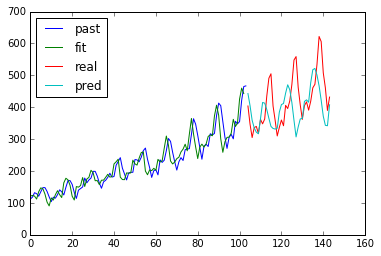

In [23]:
plt.plot(Xpast, label = 'past')
plt.plot(Xfit, label = 'fit')
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(Xpred, index=Xreal.index), label = 'pred')
plt.legend(loc = 'upper left')

O modelo foi capaz de capturar tanto a sazonalidade quanto a tendência, embora o erro acumulado seja muito alto para o horizonte observado.

__Exercício__: qual o efeito de adicionar dropout às camadas mais prodfundas do modelo. Em particular, avalie o modelo considerando dropout de 20% nas últimas duas camadas (as duas que enxergam mais no passado).

Esta aula foi baseada no material de Krist Papadopoulos, disponível em https://github.com/kristpapadopoulos/seriesnet. Também foi usado material da DeepMind, os criadores da Wavenet, disponível no blog https://deepmind.com/blog/wavenet-generative-model-raw-audio/ e de Joseph Eddy, disponível em https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/.